Cloned HMM

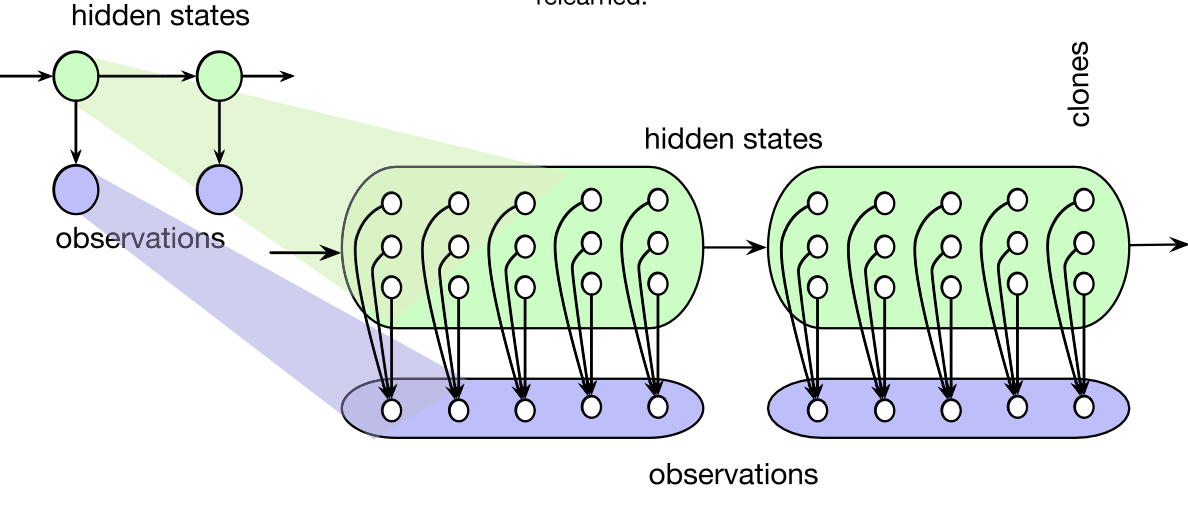

Big picture (training procedure):

1. Train transition matrix of CHMM on a long sequence using E-M (specifically, the simplified Baum-Welch algorithm, which uses message passing (the 'forward-backward algorithm') for the E-step).
2. Refine training using Viterbi on the **same** sequence (this seems to amount to: (a) infer maximum a posteriori hidden sequence given a training sequence, (b) update transition matrix to make that sequence more likely. I wonder why specifically it's useful to do this after/ in combination with E-M)

### SETUP

In [1]:
!pip install igraph
!pip install cairocffi
!pip install numba

  Using cached igraph-0.10.4-cp39-abi3-macosx_10_9_x86_64.whl (1.9 MB)
  Using cached texttable-1.6.7-py2.py3-none-any.whl (10 kB)
  Using cached cairocffi-1.5.1.tar.gz (86 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for cairocffi: filename=cairocffi-1.5.1-py3-none-any.whl size=90523 sha256=1846923c1d83a56ac7676cd4e16f4d90166a9eeb68e7af59431c06f0a0fea721
  Stored in directory: /Users/alex/Library/Caches/pip/wheels/ea/29/15/6cdb64027c43d5d1d94561d565ff72f9b53ddfd57fcab30580
Successfully built cairocffi


In [1]:
import os
import sys
import numpy as np
import numba as nb
# import igraph
import matplotlib.pyplot as plt

from tqdm import trange
from matplotlib import cm, colors
from sklearn.decomposition import PCA

#Pretty colors for plots
custom_colors = (
    np.array(
        [
            [214, 214, 214],
            [85, 35, 157],
            [253, 252, 144],
            [114, 245, 144],
            [151, 38, 20],
            [239, 142, 192],
            [214, 134, 48],
            [140, 194, 250],
            [72, 160, 162],
        ]
    )
    / 256
)
if not os.path.exists("figures"):
    os.makedirs("figures")
if not os.path.exists("data"):
    os.makedirs("data")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Code from [chmm_actions.py](https://github.com/vicariousinc/naturecomm_cscg/blob/main/chmm_actions.py) ###

In [2]:
def validate_seq(x, a, n_clones=None):
    """Validate an input sequence of observations x and actions a"""
    assert len(x) == len(a) > 0
    assert len(x.shape) == len(a.shape) == 1, "Flatten your array first"
    assert x.dtype == a.dtype == np.int64
    assert 0 <= x.min(), "Number of emissions inconsistent with training sequence"
    if n_clones is not None:
        assert len(n_clones.shape) == 1, "Flatten your array first"
        assert n_clones.dtype == np.int64
        assert all(
            [c > 0 for c in n_clones]
        ), "You can't provide zero clones for any emission"
        n_emissions = n_clones.shape[0]
        assert (
            x.max() < n_emissions
        ), "Number of emissions inconsistent with training sequence"


# Generate a random (action, observation, ground-truth location) sequence given a room encoded as a grid of observations
def datagen_structured_obs_room(
    room,
    start_r=None,
    start_c=None,
    no_left=[],
    no_right=[],
    no_up=[],
    no_down=[],
    length=10000,
    seed=42,
):
    """room is a 2d numpy array. inaccessible locations are marked by -1.
    start_r, start_c: starting locations

    In addition, there are invisible obstructions in the room
    which disallows certain actions from certain states.

    no_left:
    no_right:
    no_up:
    no_down:

    Each of the above are list of states from which the corresponding action is not allowed.

    """
    if seed is not None:
        np.random.seed(seed)
    H, W = room.shape
    if start_r is None or start_c is None:
        start_r, start_c = np.random.randint(H), np.random.randint(W)

    actions = np.zeros(length, int)
    x = np.zeros(length, int)  # observations
    rc = np.zeros((length, 2), int)  # actual r&c

    r, c = start_r, start_c
    x[0] = room[r, c]
    rc[0] = r, c

    count = 0
    while count < length - 1:

        act_list = [0, 1, 2, 3]  # 0: left, 1: right, 2: up, 3: down
        if (r, c) in no_left:
            act_list.remove(0)
        if (r, c) in no_right:
            act_list.remove(1)
        if (r, c) in no_up:
            act_list.remove(2)
        if (r, c) in no_down:
            act_list.remove(3)

        a = np.random.choice(act_list)

        # Check for actions taking out of the matrix boundary.
        prev_r = r
        prev_c = c
        if a == 0 and 0 < c:
            c -= 1
        elif a == 1 and c < W - 1:
            c += 1
        elif a == 2 and 0 < r:
            r -= 1
        elif a == 3 and r < H - 1:
            r += 1

        # Check whether action is taking to inaccessible states.
        temp_x = room[r, c]
        if temp_x == -1:
            r = prev_r
            c = prev_c
            pass

        actions[count] = a
        x[count + 1] = room[r, c]
        rc[count + 1] = r, c
        count += 1

    return actions, x, rc


#### Functions to support main CSCG class

In [3]:
@nb.njit # Not sure if this is actually necessary/useful
def compute_p_obs(message, MAP=False):
    p_obs = message.max() if MAP else message.sum()
    assert p_obs > 0
    return p_obs, message / p_obs


@nb.njit
def forward(T_tr, Pi, n_clones, x, a, store_messages=False):
    """Log-probability of a sequence, and optionally, messages"""
    ### 
    # `T_tr`: transition matrix with last 2 dims transposed - [action, to_state, from_state] 
    # `Pi`: Iniital state distribution
    # `n_clones`: vector of number of clones per possible observation
    # `x`: sequence of observations
    # `a`: sequence of actions/control states

    # Constructs a list of hidden state indices at which each clone group starts
    state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
    dtype = T_tr.dtype.type

    # Init log likelihood
    log2_lik = np.zeros(len(x), dtype)

    # forward pass

    # first timestep: use prior
    i = x[0]
    i_start, i_stop = state_loc[i:i + 2] 
    message = Pi[i_start:i_stop].copy().astype(dtype) # Leverage the fact that p(O|S) is 0 if S isn't in O's clones
    p_obs = message.sum() # Marginalize just over clones of observation - initial probs are p(clones)
    assert p_obs > 0
    message /= p_obs # Re-normalize message: p(obs|clones) = 1
    log2_lik[0] = np.log2(p_obs)
    if store_messages:
        mess_loc = np.hstack(
            (np.array([0], dtype=n_clones.dtype), n_clones[x])
        ).cumsum()
        mess_fwd = np.empty(mess_loc[-1], dtype=dtype)
        t_start, t_stop = mess_loc[:2]
        mess_fwd[t_start:t_stop] = message
    else:
        mess_fwd = None
    # Recursively compute probs for subsequent timesteps using transition matrix
    for t in range(1, x.shape[0]):
        aij, i, j = (
            a[t - 1],
            x[t - 1],
            x[t],
        )  # at time t-1 -> t we go from observation i to observation j
        (i_start, i_stop), (j_start, j_stop) = (
            state_loc[i : i + 2],
            state_loc[j : j + 2],
        )
                  # (n_clones[j], n_clones[i]) * n_clones[i] = n_clones[j]
                  # = p(Z_{n+1}|Z_n)
        message = np.ascontiguousarray(T_tr[aij, j_start:j_stop, i_start:i_stop]).dot(
            message
        )
        p_obs = message.sum()
        assert p_obs > 0
        message /= p_obs
        log2_lik[t] = np.log2(p_obs)
        if store_messages:
            t_start, t_stop = mess_loc[t : t + 2]
            mess_fwd[t_start:t_stop] = message
    return log2_lik, mess_fwd


def forwardE(T_tr, E, Pi, n_clones, x, a, store_messages=False):
    """Log-probability of a sequence, and optionally, messages"""
    # `E`: 'Emission probabilities' (likelihood matrix)
    assert (n_clones.sum(), len(n_clones)) == E.shape
    dtype = T_tr.dtype.type

    # forward pass
    t, log2_lik = 0, np.zeros(len(x), dtype)
    j = x[t]
    message = Pi * E[:, j]
    p_obs, message = compute_p_obs(message)
    log2_lik[0] = np.log2(p_obs)
    if store_messages:
        mess_fwd = np.empty((len(x), E.shape[0]), dtype=dtype)
        mess_fwd[t] = message
    for t in range(1, x.shape[0]):
        aij, j = (
            a[t - 1],
            x[t],
        )  # at time t-1 -> t we go from observation i to observation j
        message = T_tr[aij].dot(message)
        message *= E[:, j]
        p_obs, message = compute_p_obs(message)
        log2_lik[t] = np.log2(p_obs)
        if store_messages:
            mess_fwd[t] = message
    if store_messages:
        return log2_lik, mess_fwd
    else:
        return log2_lik


@nb.njit
def forward_mp(T_tr, Pi, n_clones, x, a, store_messages=False):
    """Log-probability of a sequence, and optionally, messages"""
    ### Version of forward pass used for max-product message passing / MAP inference of latents
    # The difference to `forward` is just that rather than marginalizing over clones to get p(obs) we 
    # take the max likelihood clone
    state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
    dtype = T_tr.dtype.type

    # forward pass
    t, log2_lik = 0, np.zeros(len(x), dtype)
    j = x[t]
    j_start, j_stop = state_loc[j : j + 2]
    message = Pi[j_start:j_stop].copy().astype(dtype)

    p_obs = message.max()
    assert p_obs > 0
    message /= p_obs
    log2_lik[0] = np.log2(p_obs)
    if store_messages:
        mess_loc = np.hstack(
            (np.array([0], dtype=n_clones.dtype), n_clones[x])
        ).cumsum()
        mess_fwd = np.empty(mess_loc[-1], dtype=dtype)
        t_start, t_stop = mess_loc[t : t + 2]
        mess_fwd[t_start:t_stop] = message
    else:
        mess_fwd = None

    for t in range(1, x.shape[0]):
        aij, i, j = (
            a[t - 1],
            x[t - 1],
            x[t],
        )  # at time t-1 -> t we go from observation i to observation j
        (i_start, i_stop), (j_start, j_stop) = (
            state_loc[i : i + 2],
            state_loc[j : j + 2],
        )
        new_message = np.zeros(j_stop - j_start, dtype=dtype)
        for d in range(len(new_message)):
            new_message[d] = (T_tr[aij, j_start + d, i_start:i_stop] * message).max()        
        message = new_message
        p_obs = message.max()
        assert p_obs > 0
        message /= p_obs
        log2_lik[t] = np.log2(p_obs)
        if store_messages:
            t_start, t_stop = mess_loc[t : t + 2]
            mess_fwd[t_start:t_stop] = message
    return log2_lik, mess_fwd
  

def forwardE_mp(T_tr, E, Pi, n_clones, x, a, store_messages=False):
    """Log-probability of a sequence, and optionally, messages"""
    assert (n_clones.sum(), len(n_clones)) == E.shape
    dtype = T_tr.dtype.type

    # forward pass
    t, log2_lik = 0, np.zeros(len(x), dtype)
    j = x[t]
    message = Pi * E[:, j]
    p_obs, message = compute_p_obs(message, MAP=True)

    # p_obs = message.max()
    # assert p_obs > 0
    # message /= p_obs
    log2_lik[0] = np.log2(p_obs)
    if store_messages:
        mess_fwd = np.empty((len(x), E.shape[0]), dtype=dtype)
        mess_fwd[t] = message
    for t in range(1, x.shape[0]):
        aij, j = (
            a[t - 1],
            x[t],
        )  # at time t-1 -> t we go from observation i to observation j
        message = (T_tr[aij] * message.reshape(1, -1)).max(1)
        message *= E[:, j]
        p_obs, message = compute_p_obs(message, MAP=True)
        # p_obs = message.max()
        # assert p_obs > 0
        # message /= p_obs
        log2_lik[t] = np.log2(p_obs)
        if store_messages:
            mess_fwd[t] = message
    if store_messages:
        return log2_lik, mess_fwd
    else:
        return log2_lik


def forward_mp_all(T_tr, Pi_x, Pi_a, n_clones, target_state, max_steps):
    """Log-probability of a sequence, and optionally, messages"""
    # Compute likelihood using all hidden states, not just clones of observation
    # forward pass
    t, log2_lik = 0, []
    message = Pi_x
    p_obs, message = compute_p_obs(message, MAP=True)
    # p_obs = message.max()
    # assert p_obs > 0
    # message /= p_obs
    log2_lik.append(np.log2(p_obs))
    mess_fwd = []
    mess_fwd.append(message)
    T_tr_maxa = (T_tr * Pi_a.reshape(-1, 1, 1)).max(0)
    for t in range(1, max_steps):
        message = (T_tr_maxa * message.reshape(1, -1)).max(1)
        p_obs, message = compute_p_obs(message, MAP=True)
        # p_obs = message.max()
        # assert p_obs > 0
        # message /= p_obs
        log2_lik.append(np.log2(p_obs))
        mess_fwd.append(message)
        if message[target_state] > 0:
            break
    else:
        assert False, "Unable to find a bridging path"
    return np.array(log2_lik), np.array(mess_fwd)


##### Backward message passing / state inference

In [4]:
@nb.njit
def rargmax(x):
    # return x.argmax()  # <- favors clustering towards smaller state numbers
    return np.random.choice((x == x.max()).nonzero()[0])


@nb.njit
def backtrace(T, n_clones, x, a, mess_fwd):
    """Compute backward messages."""
    state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
    mess_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones[x])).cumsum()
    code = np.zeros(x.shape[0], dtype=np.int64)

    # backward pass
    t = x.shape[0] - 1
    i = x[t]
    t_start, t_stop = mess_loc[t : t + 2]
    belief = mess_fwd[t_start:t_stop]
    code[t] = rargmax(belief)
    for t in range(x.shape[0] - 2, -1, -1):
        aij, i, j = (
            a[t],
            x[t],
            x[t + 1],
        )  # at time t -> t+1 we go from observation i to observation j
        (i_start, i_stop), j_start = state_loc[i : i + 2], state_loc[j]
        t_start, t_stop = mess_loc[t : t + 2]
        belief = (
            mess_fwd[t_start:t_stop] * T[aij, i_start:i_stop, j_start + code[t + 1]]
        )
        code[t] = rargmax(belief)
    states = state_loc[x] + code
    return states
    

def backwardE(T, E, n_clones, x, a):
    """Compute backward messages."""
    assert (n_clones.sum(), len(n_clones)) == E.shape
    dtype = T.dtype.type

    # backward pass
    t = x.shape[0] - 1
    message = np.ones(E.shape[0], dtype)
    message /= message.sum()
    mess_bwd = np.empty((len(x), E.shape[0]), dtype=dtype)
    mess_bwd[t] = message
    for t in range(x.shape[0] - 2, -1, -1):
        aij, j = (
            a[t],
            x[t + 1],
        )  # at time t -> t+1 we go from observation i to observation j
        message = T[aij].dot(message * E[:, j])
        p_obs, message = compute_p_obs(message)
        # p_obs = message.sum()
        # assert p_obs > 0
        # message /= p_obs
        mess_bwd[t] = message
    return mess_bwd


def backtraceE(T, E, n_clones, x, a, mess_fwd):
    """Compute backward messages."""
    assert (n_clones.sum(), len(n_clones)) == E.shape
    states = np.zeros(x.shape[0], dtype=np.int64)

    # backward pass
    t = x.shape[0] - 1
    belief = mess_fwd[t]
    states[t] = rargmax(belief)
    for t in range(x.shape[0] - 2, -1, -1):
        aij = a[t]  # at time t -> t+1 we go from observation i to observation j
        belief = mess_fwd[t] * T[aij, :, states[t + 1]]
        states[t] = rargmax(belief)
    return states


@nb.njit
def backward(T, n_clones, x, a):
    """Compute backward messages."""
    state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
    dtype = T.dtype.type

    # backward pass
    t = x.shape[0] - 1
    i = x[t]
    message = np.ones(n_clones[i], dtype) / n_clones[i]
    message /= message.sum()
    mess_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones[x])).cumsum()
    mess_bwd = np.empty(mess_loc[-1], dtype)
    t_start, t_stop = mess_loc[t : t + 2]
    mess_bwd[t_start:t_stop] = message
    for t in range(x.shape[0] - 2, -1, -1):
        aij, i, j = (
            a[t],
            x[t],
            x[t + 1],
        )  # at time t -> t+1 we go from observation i to observation j
        (i_start, i_stop), (j_start, j_stop) = (
            state_loc[i : i + 2],
            state_loc[j : j + 2],
        )
        message = np.ascontiguousarray(T[aij, i_start:i_stop, j_start:j_stop]).dot(
            message
        )
        p_obs, message = compute_p_obs(message)
        # p_obs = message.sum()
        # assert p_obs > 0
        # message /= p_obs
        t_start, t_stop = mess_loc[t : t + 2]
        mess_bwd[t_start:t_stop] = message
    return mess_bwd


def backtrace_all(T, Pi_a, n_clones, mess_fwd, target_state):
    """Compute backward messages."""
    states = np.zeros(mess_fwd.shape[0], dtype=np.int64)
    actions = np.zeros(mess_fwd.shape[0], dtype=np.int64)
    n_states = T.shape[1]
    # backward pass
    t = mess_fwd.shape[0] - 1
    actions[t], states[t] = (
        -1,
        target_state,
    )  # last actions is irrelevant, use an invalid value
    for t in range(mess_fwd.shape[0] - 2, -1, -1):
        belief = (
            mess_fwd[t].reshape(1, -1) * T[:, :, states[t + 1]] * Pi_a.reshape(-1, 1)
        )
        a_s = rargmax(belief.flatten())
        actions[t], states[t] = a_s // n_states, a_s % n_states
    return actions, states


##### Update transition matrix

In [5]:
@nb.njit
def updateC(C, T, n_clones, mess_fwd, mess_bwd, x, a):
    # Reset / update pseudocounts matrix
    state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
    mess_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones[x])).cumsum()
    timesteps = len(x)
    C[:] = 0
    for t in range(1, timesteps):
        aij, i, j = (
            a[t - 1],
            x[t - 1],
            x[t],
        )  # at time t-1 -> t we go from observation i to observation j
        (tm1_start, tm1_stop), (t_start, t_stop) = (
            mess_loc[t - 1 : t + 1],
            mess_loc[t : t + 2],
        )
        (i_start, i_stop), (j_start, j_stop) = (
            state_loc[i : i + 2],
            state_loc[j : j + 2],
        )
        # Compute unnormalized variational density(?) as product of transition matrix, forward and backward messages
        q = (
            mess_fwd[tm1_start:tm1_stop].reshape(-1, 1)
            * T[aij, i_start:i_stop, j_start:j_stop]
            * mess_bwd[t_start:t_stop].reshape(1, -1)
        )
        q /= q.sum()
        # Treating probabilities over hidden states as "soft" aggregated states for pseudocount update
        C[aij, i_start:i_stop, j_start:j_stop] += q
        

def updateCE(CE, E, n_clones, mess_fwd, mess_bwd, x, a):
    timesteps = len(x)
    gamma = mess_fwd * mess_bwd
    norm = gamma.sum(1, keepdims=True)
    norm[norm == 0] = 1
    gamma /= norm
    CE[:] = 0
    for t in range(timesteps):
        CE[:, x[t]] += gamma[t]


#### Main CHMM (CSCG) class

In [6]:
def plot_graph(
    chmm, x, a, output_file, cmap=cm.Spectral, multiple_episodes=False, vertex_size=30
):
    states = chmm.decode(x, a)[1]
  
    v = np.unique(states)
    if multiple_episodes:
        T = chmm.C[:, v][:, :, v][:-1, 1:, 1:]
        v = v[1:]
    else:
        T = chmm.C[:, v][:, :, v]
    A = T.sum(0)
    A /= A.sum(1, keepdims=True)

    g = igraph.Graph.Adjacency((A > 0).tolist())
    node_labels = np.arange(x.max() + 1).repeat(n_clones)[v]
    if multiple_episodes:
        node_labels -= 1
    colors = [cmap(nl)[:3] for nl in node_labels / node_labels.max()]
    out = igraph.plot(
        g,
        output_file,
        layout=g.layout("kamada_kawai"),
        vertex_color=colors,
        vertex_label=v,
        vertex_size=vertex_size,
        margin=50,
    )

    return out


def get_mess_fwd(chmm, x, pseudocount=0.0, pseudocount_E=0.0):
    n_clones = chmm.n_clones
    E = np.zeros((n_clones.sum(), len(n_clones)))
    last = 0
    for c in range(len(n_clones)):
        E[last : last + n_clones[c], c] = 1
        last += n_clones[c]
    E += pseudocount_E
    norm = E.sum(1, keepdims=True)
    norm[norm == 0] = 1
    E /= norm
    T = chmm.C + pseudocount
    norm = T.sum(2, keepdims=True)
    norm[norm == 0] = 1
    T /= norm
    T = T.mean(0, keepdims=True)
    log2_lik, mess_fwd = forwardE(
        T.transpose(0, 2, 1), E, chmm.Pi_x, chmm.n_clones, x, x * 0, store_messages=True
    )
    return mess_fwd


def place_field(mess_fwd, rc, clone):
    assert mess_fwd.shape[0] == rc.shape[0] and clone < mess_fwd.shape[1]
    field = np.zeros(rc.max(0) + 1)
    count = np.zeros(rc.max(0) + 1, int)
    for t in range(mess_fwd.shape[0]):
        r, c = rc[t]
        field[r, c] += mess_fwd[t, clone]
        count[r, c] += 1
    count[count == 0] = 1
    return field / count


In [7]:
class CHMM(object):
    def __init__(self, n_clones, x, a, pseudocount=0.0, dtype=np.float32, seed=42):
        """Construct a CHMM objct. n_clones is an array where n_clones[i] is the
        number of clones assigned to observation i. x and a are the observation sequences
        and action sequences, respectively."""
        # pseudocount: smoothing factor
        if seed is not None:
            np.random.seed(seed)
        self.n_clones = n_clones
        validate_seq(x, a, self.n_clones)
        assert pseudocount >= 0.0, "The pseudocount should be positive"
        print("Average number of clones:", n_clones.mean())
        self.pseudocount = pseudocount
        self.dtype = dtype
        n_states = self.n_clones.sum()
        n_actions = a.max() + 1

        # Random init of counts matrix (for updating transition probs)
        self.C = np.random.rand(n_actions, n_states, n_states).astype(dtype)
        
        # Flat distributions over states and actions
        self.Pi_x = np.ones(n_states) / n_states
        self.Pi_a = np.ones(n_actions) / n_actions

        # Create initial transition matrix (by normalizing random counts)
        self.update_T()

    def update_T(self):
        """Update the transition matrix given the accumulated counts matrix."""
        self.T = self.C + self.pseudocount
        norm = self.T.sum(2, keepdims=True)
        norm[norm == 0] = 1 # Not sure I get this
        self.T /= norm

    # def update_T(self):
    #     self.T = self.C + self.pseudocount
    #     norm = self.T.sum(2, keepdims=True)  # old model (conditional on actions)
    #     norm[norm == 0] = 1
    #     self.T /= norm
    #     norm = self.T.sum((0, 2), keepdims=True)  # new model (generates actions too)
    #     norm[norm == 0] = 1
    #     self.T /= norm

    def update_E(self, CE):
        """Update the emission matrix.""" # Likelihood
        E = CE + self.pseudocount
        norm = E.sum(1, keepdims=True)
        norm[norm == 0] = 1
        E /= norm
        return E

    def bps(self, x, a):
        """Compute the log likelihood (log base 2) of a sequence of observations and actions."""
        validate_seq(x, a, self.n_clones)
        log2_lik = forward(self.T.transpose(0, 2, 1), self.Pi_x, self.n_clones, x, a)[0]
        return -log2_lik

    def bpsE(self, E, x, a):
        """Compute the log likelihood using an alternate emission matrix."""
        validate_seq(x, a, self.n_clones)
        log2_lik = forwardE(
            self.T.transpose(0, 2, 1), E, self.Pi_x, self.n_clones, x, a
        )
        return -log2_lik

    def bpsV(self, x, a):
        ## What is this?
        validate_seq(x, a, self.n_clones)
        log2_lik = forward_mp(
            self.T.transpose(0, 2, 1), self.Pi_x, self.n_clones, x, a
        )[0]
        return -log2_lik

    def decode(self, x, a):
        """Compute the MAP assignment of latent variables using max-product message passing."""
        log2_lik, mess_fwd = forward_mp(
            self.T.transpose(0, 2, 1),
            self.Pi_x,
            self.n_clones,
            x,
            a,
            store_messages=True,
        )
        states = backtrace(self.T, self.n_clones, x, a, mess_fwd)
        return -log2_lik, states

    def decodeE(self, E, x, a):
        """Compute the MAP assignment of latent variables using max-product message passing
        with an alternative emission matrix."""
        log2_lik, mess_fwd = forwardE_mp(
            self.T.transpose(0, 2, 1),
            E,
            self.Pi_x,
            self.n_clones,
            x,
            a,
            store_messages=True,
        )
        states = backtraceE(self.T, E, self.n_clones, x, a, mess_fwd)
        return -log2_lik, states

    def learn_em_T(self, x, a, n_iter=100, term_early=True, save_every=None):
        """Run EM training, keeping E deterministic and fixed, learning T"""
        sys.stdout.flush()
        convergence = []
        pbar = trange(n_iter, position=0)
        log2_lik_old = -np.inf
        for it in pbar:
            # E

            # Forward pass: entire [observation, action] sequence at once
            # 
            log2_lik, mess_fwd = forward(
                self.T.transpose(0, 2, 1),
                self.Pi_x,
                self.n_clones,
                x,
                a,
                store_messages=True,
            )
            mess_bwd = backward(self.T, self.n_clones, x, a)
            # Update pseudocounts, using transition matrix, forward and backward messages and sequence
            updateC(self.C, self.T, self.n_clones, mess_fwd, mess_bwd, x, a)
            # M
            self.update_T() # Not much to this 'M step': use the already-computed counts and normalize
            convergence.append(-log2_lik.mean())
            pbar.set_postfix(train_bps=convergence[-1])
            if log2_lik.mean() <= log2_lik_old:
                if term_early:
                    break
            log2_lik_old = log2_lik.mean()

            if save_every is not None and it % save_every == 0:
                np.save("data/transitions2", self.T)
        return convergence

    def learn_viterbi_T(self, x, a, n_iter=100, save_every=None):
        """Run Viterbi training, keeping E deterministic and fixed, learning T"""
        sys.stdout.flush()
        convergence = []
        pbar = trange(n_iter, position=0)
        log2_lik_old = -np.inf
        for it in pbar:
            # E - (Diff from EM: `forawrd_mp`; uses max prob instead of marginalizing)
            log2_lik, mess_fwd = forward_mp(
                self.T.transpose(0, 2, 1),
                self.Pi_x,
                self.n_clones,
                x,
                a,
                store_messages=True,
            )
            # `backtrace` also different from EM
            # This returns a maximum a posteriori estimate of the hidden sequence, given obs sequence
            states = backtrace(self.T, self.n_clones, x, a, mess_fwd) 
            # Update count/transition matrices to make inferred hidden sequence more likely
            # (What is this doing? )
            self.C[:] = 0
            for t in range(1, len(x)):
                aij, i, j = (
                    a[t - 1],
                    states[t - 1],
                    states[t],
                )  # at time t-1 -> t we go from observation i to observation j
                self.C[aij, i, j] += 1.0
            # M
            self.update_T()
            convergence.append(-log2_lik.mean())
            pbar.set_postfix(train_bps=convergence[-1])
            if log2_lik.mean() <= log2_lik_old:
                pass #break
            log2_lik_old = log2_lik.mean()

            if save_every is not None and it % save_every == 0:
                np.save("data/transitions", self.T)
        return convergence

    def learn_em_E(self, x, a, n_iter=100, pseudocount_extra=1e-20):
        """Run Viterbi training, keeping T fixed, learning E"""
        sys.stdout.flush()
        n_emissions, n_states = len(self.n_clones), self.n_clones.sum()
        CE = np.ones((n_states, n_emissions), self.dtype)
        E = self.update_E(CE + pseudocount_extra)
        convergence = []
        pbar = trange(n_iter, position=0)
        log2_lik_old = -np.inf
        for it in pbar:
            # E
            log2_lik, mess_fwd = forwardE(
                self.T.transpose(0, 2, 1),
                E,
                self.Pi_x,
                self.n_clones,
                x,
                a,
                store_messages=True,
            )
            mess_bwd = backwardE(self.T, E, self.n_clones, x, a)
            updateCE(CE, E, self.n_clones, mess_fwd, mess_bwd, x, a)
            # M
            E = self.update_E(CE + pseudocount_extra)
            convergence.append(-log2_lik.mean())
            pbar.set_postfix(train_bps=convergence[-1])
            if log2_lik.mean() <= log2_lik_old:
                break
            log2_lik_old = log2_lik.mean()
        return convergence, E

    def sample(self, length):
        """Sample from the CHMM."""
        assert length > 0
        state_loc = np.hstack(([0], self.n_clones)).cumsum(0)
        sample_x = np.zeros(length, dtype=np.int64)
        sample_a = np.random.choice(len(self.Pi_a), size=length, p=self.Pi_a)

        # Sample
        p_h = self.Pi_x
        for t in range(length):
            h = np.random.choice(len(p_h), p=p_h)
            sample_x[t] = np.digitize(h, state_loc) - 1
            p_h = self.T[sample_a[t], h]
        return sample_x, sample_a

    def sample_sym(self, sym, length):
        """Sample from the CHMM conditioning on an inital observation."""
        # Prepare structures
        assert length > 0
        state_loc = np.hstack(([0], self.n_clones)).cumsum(0)

        seq = [sym]

        alpha = np.ones(self.n_clones[sym])
        alpha /= alpha.sum()

        for _ in range(length):
            obs_tm1 = seq[-1]
            T_weighted = self.T.sum(0)

            long_alpha = np.dot(
                alpha, T_weighted[state_loc[obs_tm1] : state_loc[obs_tm1 + 1], :]
            )
            long_alpha /= long_alpha.sum()
            idx = np.random.choice(np.arange(self.n_clones.sum()), p=long_alpha)

            sym = np.digitize(idx, state_loc) - 1
            seq.append(sym)

            temp_alpha = long_alpha[state_loc[sym] : state_loc[sym + 1]]
            temp_alpha /= temp_alpha.sum()
            alpha = temp_alpha

        return seq

    def bridge(self, state1, state2, max_steps=100):
        Pi_x = np.zeros(self.n_clones.sum(), dtype=self.dtype)
        Pi_x[state1] = 1
        log2_lik, mess_fwd = forward_mp_all(
            self.T.transpose(0, 2, 1), Pi_x, self.Pi_a, self.n_clones, state2, max_steps
        )
        s_a = backtrace_all(self.T, self.Pi_a, self.n_clones, mess_fwd, state2)
        return s_a

## Code below (up to "text experiments") is Vicarious's original notebook

# Training a CHMM

In [9]:
# Train CHMM on random data
TIMESTEPS = 1000
OBS = 2
x = np.random.randint(OBS, size=(1000,))  # Observations. Replace with your data.
a = np.zeros(
    1000, dtype=np.int64
)  # If there are actions in your domain replace this. If not, keep the vector of zeros.
n_clones = (
    np.ones(OBS, dtype=np.int64) * 5
)  # Number of clones specifies the capacity for each observation.

x_test = np.random.randint(
    OBS, size=(1000,)
)  # Test observations. Replace with your data.
a_test = np.zeros(1000, dtype=np.int64)



chmm = CHMM(n_clones=n_clones, pseudocount=1e-10, x=x, a=a)  # Initialize the model
chmm.learn_em_E(x, a, n_iter=100, pseudocount_extra=1e-20)

progression = chmm.learn_em_T(x, a, n_iter=100, term_early=False)  # Training

nll_per_prediction = chmm.bps(
    x_test, a_test
)  # Evaluate negative log-likelihood (base 2 log)
avg_nll = np.mean(nll_per_prediction)
avg_prediction_probability = 2 ** (-avg_nll)
print(avg_prediction_probability)


Average number of clones: 5.0


100%|██████████| 100/100 [00:07<00:00, 13.67it/s, train_bps=0.997]


0.4994489992476265


## 

# Rectangular room datagen

In [10]:
room = np.array(
    [
        [1, 2, 3, 0, 3, 1, 1, 1],
        [1, 1, 3, 2, 3, 2, 3, 1],
        [1, 1, 2, 0, 1, 2, 1, 0],
        [0, 2, 1, 1, 3, 0, 0, 2],
        [3, 3, 1, 0, 1, 0, 3, 0],
        [2, 1, 2, 3, 3, 3, 2, 0],
    ]
)
n_emissions = room.max() + 1

a, x, rc = datagen_structured_obs_room(room, length=5000)

n_clones = np.ones(n_emissions, dtype=np.int64) * 70
# progression = chmm.learn_em_T(x, a, n_iter=1000)  # Training
# refine learning
#chmm.pseudocount = 0.0
#chmm.learn_em_T(x, a, n_iter=1)
#chmm.learn_viterbi_T(x, a, n_iter=100)

#### **Learned** "cognitive map"

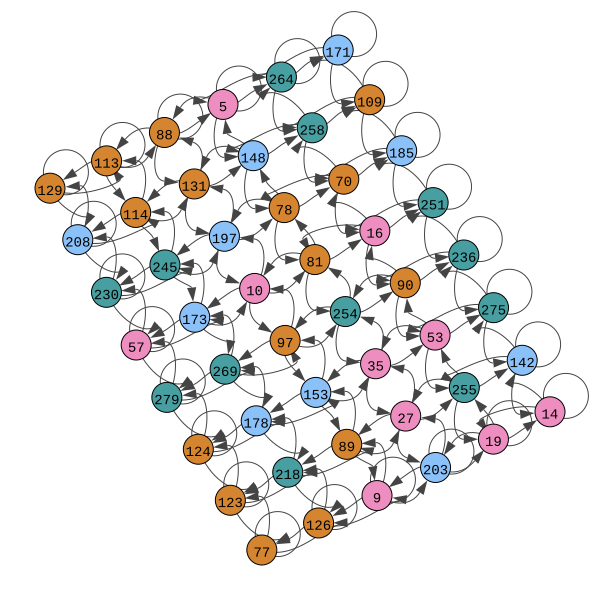

In [60]:
graph = plot_graph(
    chmm, x, a, output_file="figures/rectangular_room_graph.pdf", cmap=cmap
)
graph


#### **Visualze** "Place fields"

In [75]:
mess_fwd = get_mess_fwd(chmm, x, pseudocount_E=0.1)

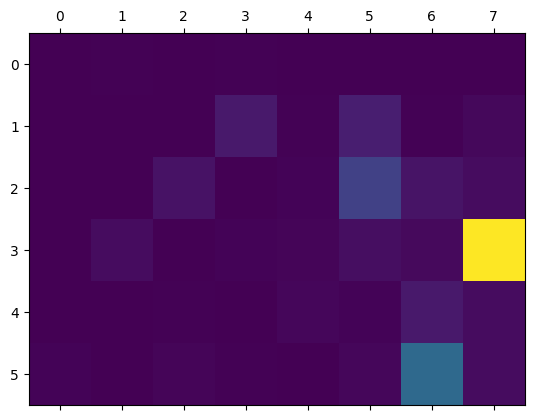

In [80]:
clone = 203
plt.matshow(place_field(mess_fwd, rc, clone))
plt.savefig("figures/rectangular_room_place_field.pdf")

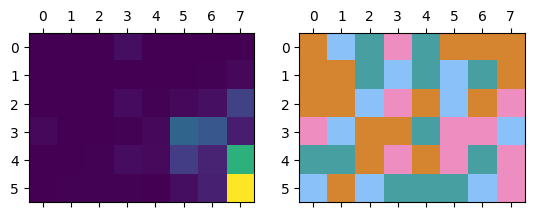

In [79]:
clone = 14
fig, (ax, ax2) = plt.subplots(1, 2)
ax.matshow(place_field(mess_fwd, rc, clone))

cmap = colors.ListedColormap(custom_colors[-4:])
ax2.matshow(room, cmap=cmap)
# plt.savefig("figures/rectangular_room_layout.pdf")

# Model sharing

In [8]:
cmap = colors.ListedColormap(custom_colors[-4:])

In [9]:
room = np.array(
    [
        [1, 2, 3, 0, 3, 1, 1, 1],
        [1, 1, 3, 2, 3, 2, 3, 1],
        [1, 1, 2, 0, 1, 2, 1, 0],
        [0, 2, 1, 1, 3, 0, 0, 2],
        [3, 3, 1, 0, 1, 0, 3, 0],
        [2, 1, 2, 3, 3, 3, 2, 0],
    ]
)
n_emissions = room.max() + 1

a, x, rc = datagen_structured_obs_room(room, length=5000, seed=None)
a2, x2, rc2 = datagen_structured_obs_room(room, length=5000, seed=None)

n_clones = np.ones(n_emissions, dtype=np.int64) * 70


In [10]:
chmm1 = CHMM(n_clones=n_clones, pseudocount=2e-3, x=x, a=a)  # Initialize the model
progression = chmm1.learn_em_T(x, a, n_iter=1000)  # Training

chmm2 = CHMM(n_clones=n_clones, pseudocount=2e-3, x=x2, a=a2)  # Initialize the model
progression2 = chmm2.learn_em_T(x2, a2, n_iter=1000)  # Training


Average number of clones: 70.0


 24%|█████▍                 | 235/1000 [00:27<01:30,  8.44it/s, train_bps=0.032]

Average number of clones: 70.0



 14%|███▏                   | 136/1000 [00:14<01:31,  9.43it/s, train_bps=0.032]


In [11]:
# refine learning
chmm1.pseudocount = 0.0
#chmm.learn_em_T(x, a, n_iter=1)
chmm1.learn_viterbi_T(x, a, n_iter=100)

chmm2.pseudocount = 0.0
#chmm.learn_em_T(x, a, n_iter=1)
chmm2.learn_viterbi_T(x2, a2, n_iter=100)


100%|██████████████████████| 100/100 [00:09<00:00, 10.24it/s, train_bps=0.00163]


[0.032252003,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.0016258566,
 0.00162585

In [20]:
graph = plot_graph(
    chmm1, x, a, output_file="figures/chmm1_rectangular_room_graph.pdf", cmap=cmap
)
graph


OSError: no library called "cairo-2" was found
no library called "cairo" was found
no library called "libcairo-2" was found
cannot load library 'libcairo.so.2': dlopen(libcairo.so.2, 0x0002): tried: 'libcairo.so.2' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibcairo.so.2' (no such file), '/Users/alex/anaconda3/envs/cscg/bin/../lib/libcairo.so.2' (no such file), '/usr/lib/libcairo.so.2' (no such file, not in dyld cache), 'libcairo.so.2' (no such file), '/usr/local/lib/libcairo.so.2' (no such file), '/usr/lib/libcairo.so.2' (no such file, not in dyld cache)
cannot load library 'libcairo.2.dylib': dlopen(libcairo.2.dylib, 0x0002): tried: 'libcairo.2.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibcairo.2.dylib' (no such file), '/Users/alex/anaconda3/envs/cscg/bin/../lib/libcairo.2.dylib' (no such file), '/usr/lib/libcairo.2.dylib' (no such file, not in dyld cache), 'libcairo.2.dylib' (no such file), '/usr/local/lib/libcairo.2.dylib' (no such file), '/usr/lib/libcairo.2.dylib' (no such file, not in dyld cache)
cannot load library 'libcairo-2.dll': dlopen(libcairo-2.dll, 0x0002): tried: 'libcairo-2.dll' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibcairo-2.dll' (no such file), '/Users/alex/anaconda3/envs/cscg/bin/../lib/libcairo-2.dll' (no such file), '/usr/lib/libcairo-2.dll' (no such file, not in dyld cache), 'libcairo-2.dll' (no such file), '/usr/local/lib/libcairo-2.dll' (no such file), '/usr/lib/libcairo-2.dll' (no such file, not in dyld cache)

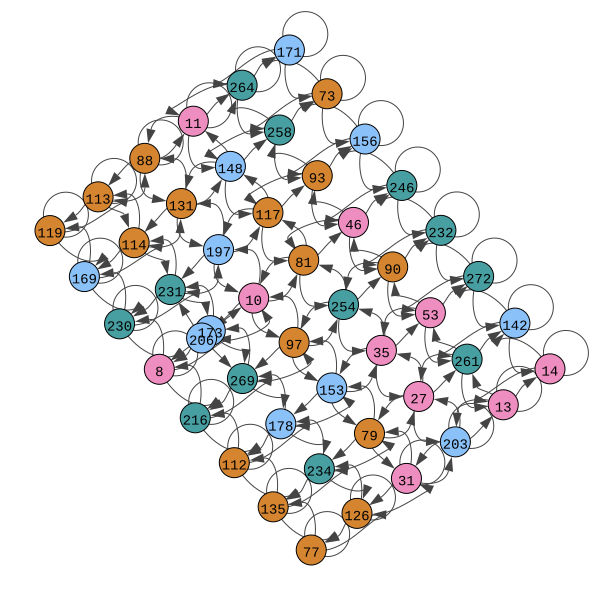

In [85]:
graph = plot_graph(
    chmm2, x4, a4, output_file="figures/rectangular_room_graph.pdf", cmap=cmap
)
graph


In [12]:
mess_fwd = get_mess_fwd(chmm1, x, pseudocount_E=0.1)

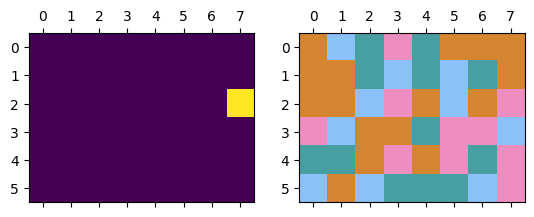

In [13]:
clone = 14
fig, (ax, ax2) = plt.subplots(1, 2)
ax.matshow(place_field(mess_fwd, rc, clone))

cmap = colors.ListedColormap(custom_colors[-4:])
ax2.matshow(room, cmap=cmap)
# plt.savefig("figures/rectangular_room_layout.pdf")

In [14]:
import torch

_cosine_sim = torch.nn.CosineSimilarity()

def cosine_sim(a, b):
    if type(a) != torch.Tensor:
        a = torch.Tensor(a)
    if type(b) != torch.Tensor:
        b = torch.Tensor(b)
    if len(a.shape) < 2:
        a = a.unsqueeze(0)
    if len(b.shape) < 2:
        b = b.unsqueeze(0)

    return torch.squeeze(torch.cat([_cosine_sim(ai, b).unsqueeze(0) for ai in a]))

    # return _cosine_sim(a, b)
  

In [37]:
a = np.zeros(280, dtype='int')
a[77] = 1

b = np.zeros(280, dtype='int')
b[23] = 1

In [120]:
# First compute mess_fwd above for chmm1 & rc3
anchors = mess_fwd[2000:2300]
probe = mess_fwd[8]

rrs1 = cosine_sim(probe, anchors)

In [15]:
# Compute "anchors"
chmm1_anchors = get_mess_fwd(chmm1, x, pseudocount_E=0.1)
chmm2_anchors = get_mess_fwd(chmm2, x, pseudocount_E=0.1)


In [15]:
def get_RR(X, anchors):
    '''Alias for batch cosine similarity'''
    return cosine_sim(X, anchors)


In [24]:
model_list = [chmm1, chmm2]
X = x

models_info = {
        f'model{i}': {
            'model': model_list[i], 
            'abs_pca': PCA(n_components=2),
            'rel_pca': PCA(n_components=2),
            'abs': dict(),
            'rel': dict(),
            'abs_mean': dict(),
            'rel_mean': dict(),
            'mess_fwd': torch.Tensor(get_mess_fwd(model_list[i], X, pseudocount_E=0.1)),
            'anchors': None
        }
        for i in range(len(model_list))
    }

In [18]:
mess_fwd = get_mess_fwd(chmm1, x, pseudocount_E=0.1)
num_dims = 1000
anchor_idxs = np.random.choice(len(mess_fwd), num_dims)

In [21]:
chmm1_anchors = mess_fwd[anchor_idxs]
chmm1_anchors.shape

(1000, 280)

In [22]:
mess_fwd2 = get_mess_fwd(chmm2, x, pseudocount_E=0.1)
num_dims = 1000
anchor_idxs2 = np.random.choice(len(mess_fwd2), num_dims)
chmm2_anchors = mess_fwd[anchor_idxs2]

In [25]:
models_info['model0']['anchors'] = chmm1_anchors
models_info['model1']['anchors'] = chmm2_anchors

In [16]:
def _format_ax(ax, model_dict, model_type, idx, epsilon, num_classes, rep_type):
    ax.set_title(f"{model_type} {idx} {rep_type} representation")
    ax.tick_params(
        axis='both',          
        which='both',  
        bottom=False,  
        top=False,    
        left=False,
        labelleft=False,
        labelbottom=False)

def _plot_means(ax, model_dict, rep_type, epsilon, num_classes, model1_classes=None):
    abs_mean = model_dict[f'all_{rep_type[:3]}_mean']
    if model1_classes is not None:
        abs_mean = abs_mean[model1_classes]
    ax.scatter(abs_mean[:,0], abs_mean[:,1], color="black")
    numbers = model1_classes if model1_classes is not None else range(num_classes)
    [ax.annotate(text=n, xy=(abs_mean[idx,0] + epsilon, abs_mean[idx,1] + epsilon)) for idx, n in enumerate(numbers)]
    
def _get_rel_PCA(models_info, model_key, rtype, use_rel_PCA):
    return models_info[f'model{use_rel_PCA}']['rel_pca'] if use_rel_PCA is not None else models_info[model_key][f'{rtype}_pca']
    
def _add_reps(models_info, idx, rep_type, use_rel_PCA:int=None):
    model_dict = models_info[idx]
    rtype = rep_type[:3]
    model_dict[f'all_{rtype}'] = torch.cat([t for k, t in model_dict[rtype].items()])
    model_dict[f'{rtype}_pca'].fit(model_dict[f'all_{rtype}'])    
    pca_to_use = _get_rel_PCA(models_info, idx, rtype, use_rel_PCA)
    model_dict[f'all_{rtype}_mean'] = pca_to_use.transform(
        torch.cat([t.unsqueeze(0) for k, t in model_dict[f'{rtype}_mean'].items()])
    )
    return model_dict


# def _get_pca_data(model_list, dataset, num_classes:int=10, use_rel_PCA:int=0):
#     models_info = {
#         f'model{i}': {
#             'model': model_list[i], 
#             'abs_pca': PCA(n_components=2),
#             'rel_pca': PCA(n_components=2),
#             'abs': dict(),
#             'rel': dict(),
#             'abs_mean': dict(),
#             'rel_mean': dict()
#         }
#         for i in range(len(model_list))
#     }

#     print("Preparing data...")
#     numbers = dict()
#     for n in range(num_classes):
#         print(f"  Processing {n}...")
#         numbers[n] = get_MNIST_by_class(dataset, n)
#         for key, model_dict in models_info.items():
#             model_dict['abs'][n] = model_dict['model'].get_embedding(numbers[n])
#             model_dict['abs_mean'][n] = torch.mean(model_dict['abs'][n], dim=0)
#             model_dict['rel'][n] = model_dict['model'].get_RR(numbers[n])
#             model_dict['rel_mean'][n] = torch.mean(model_dict['rel'][n], dim=0)
            
#             models_info[key] = _add_reps(models_info, key, 'abs')
#             models_info[key] = _add_reps(models_info, key, 'rel', use_rel_PCA)
        
#     return models_info
                  

In [26]:
def plot_latents(model_list, X, num_dims=1000, num_classes:int=4, use_rel_PCA:int=0, model_type=None, abs_epsilon=15, rel_epsilon=.3, model1_classes=list(range(4)), models_info=None):
    model_type = model_type or 'Model' 
    models_info = models_info or {
        f'model{i}': {
            'model': model_list[i], 
            'abs_pca': PCA(n_components=2),
            'rel_pca': PCA(n_components=2),
            'abs': dict(),
            'rel': dict(),
            'abs_mean': dict(),
            'rel_mean': dict(),
            'mess_fwd': torch.Tensor(get_mess_fwd(model_list[i], X, pseudocount_E=0.1)),
            'anchors': None
        }
        for i in range(len(model_list))
    }
        
    print("Preparing data...")
    # numbers = dict()
    for n in range(num_classes):
        print(f"  Processing {n}...")
        
        n_idxs = X == n
        # numbers[n] = mess_fwd[n_idxs]
        for key, model_dict in models_info.items():
            print("building anchors")
            # anchor_idxs = np.random.choice(len(model_dict['mess_fwd']), num_dims)
            # model_dict['anchors'] = torch.Tensor(model_dict
            print("doing other stuff")
            model_dict['abs'][n] = model_dict['mess_fwd'][n_idxs]
            model_dict['abs_mean'][n] = torch.mean(model_dict['abs'][n], dim=0)
            model_dict['rel'][n] = get_RR(model_dict['abs'][n], model_dict['anchors'])
            model_dict['rel_mean'][n] = torch.mean(model_dict['rel'][n], dim=0)
            
            models_info[key] = _add_reps(models_info, key, 'abs')
            models_info[key] = _add_reps(models_info, key, 'rel', use_rel_PCA)
    
    # return models_info
                                
    num_models = len(model_list)

    fig, (abs_axs, rel_axs) = plt.subplots(2, num_models)
    
    for idx, (key, model_dict) in enumerate(models_info.items()):
        for n in range(num_classes):
            if (idx == 1) or (n in model1_classes):

                abs_rep_2d = model_dict['abs_pca'].transform(model_dict['abs'][n])
                abs_axs[idx].scatter(abs_rep_2d[:,0], abs_rep_2d[:,1])

                rel_pca = _get_rel_PCA(models_info, key, 'rel', use_rel_PCA)
                rel_rep_2d = rel_pca.transform(model_dict['rel'][n])
                rel_axs[idx].scatter(rel_rep_2d[:,0], rel_rep_2d[:,1])
            if (idx == 0) and (n not in model1_classes):
                abs_axs[idx].scatter([-1], [-1],s=0)
                rel_axs[idx].scatter([-1], [-1],s=0)
        
        ax = abs_axs[idx]
        _format_ax(ax, model_dict, model_type, idx, abs_epsilon, num_classes, 'absolute')
        _plot_means(ax, model_dict, 'abs', abs_epsilon, num_classes, model1_classes if idx == 0 else None)
        ax = rel_axs[idx]
        _format_ax(ax, model_dict, model_type, idx, rel_epsilon, num_classes, 'relative')
        _plot_means(ax, model_dict, 'rel', rel_epsilon, num_classes, model1_classes if idx == 0 else None)

    fig.set_figwidth(10)
    fig.set_figheight(10)
    
    return models_info

In [ ]:
mi = plot_latents([chmm1, chmm2], x, models_info=models_info)

Preparing data...
  Processing 0...
building anchors
doing other stuff


In [16]:
torch.Tensor(get_mess_fwd(chmm1, x, pseudocount_E=0.1))

tensor([[0.0112, 0.0112, 0.0112,  ..., 0.0010, 0.0010, 0.0010],
        [0.0000, 0.0703, 0.0000,  ..., 0.0000, 0.0000, 0.0064],
        [0.0000, 0.0513, 0.0000,  ..., 0.0000, 0.0000, 0.0040],
        ...,
        [0.0000, 0.0328, 0.0000,  ..., 0.0000, 0.0000, 0.0291],
        [0.0000, 0.2578, 0.0000,  ..., 0.0000, 0.0000, 0.0262],
        [0.0000, 0.0175, 0.0000,  ..., 0.0000, 0.0000, 0.0197]])

In [26]:
x[:20]

(5000,)

In [ ]:
x

array([ True,  True,  True, ...,  True,  True, False])